In [6]:
import os
import re
import tempfile
import warnings

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
import tqdm
from hyperopt import STATUS_OK, SparkTrials, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from lightgbm import LGBMClassifier
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema
from pyspark.sql import SparkSession
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from JapanHorseRaceAnalytics.utilities.base import (
    get_base_dir,
    get_spark_session,
    read_hive_table,
)
from JapanHorseRaceAnalytics.utilities.metrics import (
    calculate_binary_classifier_statistics,
    calculate_payout_rate,
)
from JapanHorseRaceAnalytics.utilities.mlflow import get_colspecs
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

# Set pandas display options
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)

# Set seed for reproducibility
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)
random_state = 42


shap.initjs()
japanize_matplotlib.japanize()

In [2]:
spark = get_spark_session()

24/03/07 08:01:48 WARN Utils: Your hostname, Hanks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.40.105 instead (on interface en0)
24/03/07 08:01:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/03/07 08:01:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/07 08:01:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
data = read_hive_table(
    table_name="features_20240304_v1",
    schema="jhra_curated",
    spark_session=spark,
    use_cache=True,
    parse_dates=["meta_発走日時"],
)

logger.info(f"Original data shape: {data.shape}")

# drop from data where cat_トラック種別 == "障害"
data = data[(data["cat_トラック種別"] != "障害")]

# drop from data where meta_int_race_horses_異常区分 != '0'
data = data[(data["meta_int_race_horses_異常区分"] == "0")]

# keep only horses that have 3 races
data = data[
    (data["num_1走前着順"].notnull())
    & (data["num_2走前着順"].notnull())
    & (data["num_3走前着順"].notnull())
]

# Impute num_入厩何日前
data["num_入厩何日前"].fillna(0, inplace=True)

logger.info(f"Data shape after filtering: {data.shape}")

data.reset_index(drop=True, inplace=True)
data.head()

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240304_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-03-06T23:01:49.426159Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
{"event": "Original data shape: (1108166, 23)", "level": "info", "timestamp": "2024-03-06T23:01:49.607434Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
{"event": "Data shape after filtering: (752305, 23)", "level": "info", "timestamp": "2024-03-06T23:01:49.868890Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}


,meta_レースキー,meta_馬番,meta_着順,meta_発走日時,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,meta_int_race_horses_異常区分,meta_実績複勝オッズ,cat_トラック種別,num_1走前着順,num_2走前着順,num_3走前着順,num_複勝率,num_入厩何日前,num_入厩何日前逆数,num_過去3走重み付き着順成績,cat_堅実な馬,cat_訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり
0,01011102,01,5.0,2001-08-04 10:15:00+09:00,51.0,False,0,False,0,0,2.9,ダート,7.0,8.0,2.0,0.250000,0.0,1.0,0.174604,False,False,True,False
1,01011102,05,4.0,2001-08-04 10:15:00+09:00,77.0,False,0,False,0,0,1.1,ダート,4.0,3.0,4.0,0.333333,0.0,1.0,0.077879,False,False,False,False
2,01011107,07,5.0,2001-08-04 13:15:00+09:00,75.0,False,0,False,0,0,2.0,ダート,1.0,2.0,3.0,1.000000,0.0,1.0,0.004530,False,False,False,False
3,01011110,01,9.0,2001-08-04 14:55:00+09:00,0.0,False,0,False,0,0,10.4,芝,10.0,6.0,1.0,0.333333,0.0,1.0,0.207357,False,False,True,False
4,01011111,13,8.0,2001-08-04 15:30:00+09:00,0.0,False,0,False,0,0,10.2,ダート,7.0,8.0,1.0,0.333333,0.0,1.0,0.134168,False,False,True,False


In [4]:
data.columns

Index(['meta_レースキー', 'meta_馬番', 'meta_着順', 'meta_発走日時', 'meta_本賞金',
       'meta_単勝的中', 'meta_単勝払戻金', 'meta_複勝的中', 'meta_複勝払戻金',
       'meta_int_race_horses_異常区分', 'meta_実績複勝オッズ', 'cat_トラック種別', 'num_1走前着順',
       'num_2走前着順', 'num_3走前着順', 'num_複勝率', 'num_入厩何日前', 'num_入厩何日前逆数',
       'num_過去3走重み付き着順成績', 'cat_堅実な馬', 'cat_訳あり凡走', 'cat_過去3走中2走好走',
       'cat_過去3走繋がりあり'],
      dtype='object')

In [4]:
num_cols = [
    "num_1走前着順",
    "num_2走前着順",
    "num_3走前着順",
    "num_複勝率",
    "num_入厩何日前",
    # "num_入厩何日前逆数", # Handling NULL?
    "num_過去3走重み付き着順成績",
]

cat_cols = [
    "cat_トラック種別",
    "cat_堅実な馬",
    "cat_訳あり凡走",
    "cat_過去3走中2走好走",
    "cat_過去3走繋がりあり",
]

train_cols = num_cols + cat_cols
meta_cols = ["meta_レースキー", "meta_複勝的中", "meta_複勝払戻金"]
all_cols = num_cols + cat_cols + meta_cols

preprocessor = ColumnTransformer(
    transformers=[
        # fmt: off
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
        # fmt: on
    ],
    remainder="drop",
)

pipeline = ImblearnPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=random_state)),
        ("classifier", LGBMClassifier(random_state=random_state)),
    ]
)

X = data
y = data["meta_複勝的中"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (601844, 23)
X_test: (150461, 23)
y_train: (601844,)
y_test: (150461,)


In [7]:
def create_objective_fn(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    df_payout: pd.DataFrame,
    experiment_name: str,
):
    """
    df_payout should have the same index as *_test and have the following columns:
    * レースキー
    * 馬番
    * 発走日時
    * payout - amount won if betting 100 yen.
    """

    def train(params):
        mlflow.set_experiment(experiment_name=experiment_name)
        with mlflow.start_run():
            mlflow.log_params(params)

            preprocessor = ColumnTransformer(
                transformers=[
                    # fmt: off
                    ("num", StandardScaler(), num_cols),
                    ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
                    # fmt: on
                ],
                remainder="drop",
            )

            model = ImblearnPipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("smote", SMOTE(random_state=random_state)),
                    ("classifier", LGBMClassifier(**params)),
                ]
            )

            model.fit(X_train, y_train)
            mlflow.sklearn.log_model(sk_model=model, artifact_path="model")

            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            metrics = {
                "loss": log_loss(y_test, y_pred_proba),
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred),
                "recall": recall_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred),
                "roc_auc": roc_auc_score(y_test, y_pred),
            }
            mlflow.log_metrics(metrics)

            # Calculate payout rates by group
            # results = pd.concat(
            #     [
            #         df_payout,
            #         pd.DataFrame(
            #             np.c_[y_test, y_pred_proba],
            #             columns=["actual", "proba_true"],
            #         ),
            #     ],
            #     axis=1,
            # )
            # payout_all = calculate_binary_classifier_statistics(
            #     results, group_by=None, payout_column_name="payout"
            # )
            # payout_month = calculate_binary_classifier_statistics(
            #     results,
            #     group_by=results["発走日時"].dt.month,
            #     payout_column_name="payout",
            # )
            # payout_season = calculate_binary_classifier_statistics(
            #     results,
            #     group_by=results["発走日時"].dt.month % 12 // 3,
            #     payout_column_name="payout",
            # )
            # payout_year = calculate_binary_classifier_statistics(
            #     results,
            #     group_by=results["発走日時"].dt.year,
            #     payout_column_name="payout",
            # )
            # payout = (
            #     pd.concat(
            #         [
            #             pd.DataFrame(payout_all).T.assign(group="all"),
            #             pd.DataFrame(payout_month).T.assign(group="month"),
            #             pd.DataFrame(payout_season).T.assign(group="season"),
            #             pd.DataFrame(payout_year).T.assign(group="year"),
            #         ],
            #         axis=0,
            #     )
            #     .rename_axis(index="part")
            #     .reset_index()
            # )
            # # Move "group" and "part" columns to the first position in this dataframe
            # payout = payout[
            #     ["group", "part"]
            #     + [c for c in payout.columns if c not in ["group", "part"]]
            # ]
            payout = calculate_payout_rate(
                payouts=df_payout,
                y_test=y_test,
                y_proba_true=y_pred_proba,
                groupby=[
                    ("all", None),
                    ("month", df_payout["発走日時"].dt.month),
                    ("season", df_payout["発走日時"].dt.month % 12 // 3),
                    ("year", df_payout["発走日時"].dt.year),
                ],
                payout_column_name="payout",
            )

            # Save payout rates as csv
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".csv") as f:
                payout.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            # Log payout rates as metrics
            payout_metrics = {}
            for group_name, group in payout.groupby("group"):
                for i, row in group.iterrows():
                    key = re.sub(r"\W", "_", f"payout_rate_{group_name}_{row['part']}")
                    payout_metrics[key] = row["payout_rate"]
            mlflow.log_metrics(payout_metrics)

            # Suppress UserWarning messages from matplotlib
            warnings.filterwarnings("ignore", category=UserWarning)

            # Plot payout rates by group
            sns.set_theme(style="whitegrid")
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            for (group, df), ax in zip(payout.groupby("group"), axes.flatten()):
                sns.barplot(x="part", y="payout_rate", data=df, ax=ax)
                ax.set_title(group)
                ax.set_ylim(0, 150)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
                ax.set_ylabel("payout rate")
                ax.set_xlabel("")
                ax.yaxis.set_major_formatter(ticker.PercentFormatter())
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Confusion Matrix
            conf_matrix = confusion_matrix(y_test, y_pred)
            _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", ax=ax1)
            ax1.set_xlabel("Predicted")
            ax1.set_ylabel("Actual")
            ax1.set_title("Confusion Matrix")
            sns.heatmap(
                conf_matrix / conf_matrix.sum(axis=1)[:, None],
                annot=True,
                fmt=".2%",
                cmap="Blues",
                ax=ax2,
            )
            ax2.set_xlabel("Predicted")
            ax2.set_ylabel("Actual")
            ax2.set_title("Normalized Confusion Matrix")
            with tempfile.NamedTemporaryFile(
                prefix="confusion_matrix_", suffix=".png"
            ) as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            _, ax = plt.subplots(figsize=(10, 10))
            ax.plot(
                fpr,
                tpr,
                color="darkorange",
                lw=2,
                label="ROC curve (area = %0.2f)" % roc_auc,
            )
            ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.0])
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.set_title("Receiver Operating Characteristic")
            ax.legend(loc="lower right")
            with tempfile.NamedTemporaryFile(prefix="roc_curve_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances
            feature_importances = zip(
                model.named_steps["preprocessor"].get_feature_names_out(),
                model.named_steps["classifier"].feature_importances_,
            )
            feature_importances_df = (
                pd.DataFrame(
                    data=feature_importances, columns=["feature", "importance"]
                )
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_", suffix=".csv"
            ) as f:
                feature_importances_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)
            font_properties = fm.FontProperties(
                fname="/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
            )

            sns.set_theme(style="whitegrid")
            plt.figure(figsize=(10, 12))
            ax = sns.barplot(
                x="importance", y="feature", data=feature_importances_df.iloc[:50]
            )
            ax.set_title("Feature Importances (Top 50)", fontproperties=font_properties)
            ax.set_xlabel("Importance", fontproperties=font_properties)
            ax.set_ylabel("Features", fontproperties=font_properties)
            for label in ax.get_yticklabels():
                label.set_fontproperties(font_properties)
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_", suffix=".png"
            ) as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            return {"status": STATUS_OK, "params": params, "model": model, **metrics}

    return train

In [14]:
space = {
    # "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"]),
    "boosting_type": "gbdt",
    "learning_rate": hp.loguniform("learning_rate", -5, 0),  # between e^-5 and 1
    "n_estimators": scope.int(hp.quniform("n_estimators", 100, 1000, 1)),
    "max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    "num_leaves": scope.int(hp.quniform("num_leaves", 20, 150, 1)),
    "min_child_samples": scope.int(hp.quniform("min_child_samples", 20, 500, 1)),
    "feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "lambda_l1": hp.uniform("lambda_l1", 0, 5),
    "lambda_l2": hp.uniform("lambda_l2", 0, 5),
    "min_split_gain": hp.uniform("min_split_gain", 0, 1),
    "min_child_weight": hp.uniform("min_child_weight", 0.001, 10),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
    "objective": "binary",
    # "class_weight": "balanced",
    "verbose": -1,
    "seed": 80,
}

In [15]:
df_payout_renamed_columns = {
    "meta_レースキー": "レースキー",
    "meta_馬番": "馬番",
    # "cat_距離": "距離",
    "meta_発走日時": "発走日時",
    "meta_複勝払戻金": "payout",
    # "num_年齢": "年齢",
    # "meta_場コード": "場コード",
    # "num_事前複勝オッズ": "odds",
}

df_payout = (
    data.iloc[X_test.index]
    .reset_index(drop=True)
    .rename(columns=df_payout_renamed_columns)[df_payout_renamed_columns.values()]
    .assign(発走日時=lambda x: pd.to_datetime(x["発走日時"]))
)

experiment_name = "20240304_train"
if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(experiment_name)

fn = create_objective_fn(
    X_train,
    y_train,
    X_test,
    y_test,
    df_payout=df_payout,
    experiment_name=experiment_name,
)

In [10]:
df_payout.head()

,レースキー,馬番,発走日時,payout
0,09082409,03,2008-04-06 14:35:00+09:00,0
1,04093512,07,2009-08-29 16:30:00+09:00,0
2,08183205,10,2018-04-22 12:20:00+09:00,0
3,08133611,07,2013-05-05 15:30:00+09:00,0
4,08231806,06,2023-05-14 12:45:00+09:00,0


In [11]:
X_train[train_cols].head()

,num_1走前着順,num_2走前着順,num_3走前着順,num_複勝率,num_入厩何日前,num_過去3走重み付き着順成績,cat_トラック種別,cat_堅実な馬,cat_訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり
348149,3.0,8.0,18.0,0.285714,57.0,0.155029,ダート,False,True,True,True
552903,6.0,13.0,10.0,0.111111,106.0,0.158513,芝,False,False,False,False
197563,1.0,1.0,2.0,1.000000,30.0,-0.005035,ダート,False,False,False,False
749363,1.0,7.0,5.0,0.363636,43.0,0.023711,ダート,False,False,True,False
670857,9.0,12.0,13.0,0.117647,0.0,0.255602,ダート,False,False,False,False


In [16]:
# serial
trials = Trials()
fmin(fn=fn, space=space, algo=tpe.suggest, max_evals=1, trials=trials)

# parallel
# trials = SparkTrials(parallelism=4, spark_session=spark)
# fmin(fn=fn, space=space, algo=tpe.suggest, max_evals=60, trials=trials)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.002370 seconds
TPE using 0 trials
Setuptools is replacing distutils.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, 

100%|██████████| 1/1 [00:11<00:00, 11.12s/trial, best loss: 0.49157071381002504]


{'colsample_bytree': 0.6890834181861241,
 'feature_fraction': 0.7647168148972268,
 'lambda_l1': 3.1614404024976235,
 'lambda_l2': 3.1228481880461825,
 'learning_rate': 0.5040541000119978,
 'max_depth': 8.0,
 'min_child_samples': 425.0,
 'min_child_weight': 6.369759208765456,
 'min_split_gain': 0.36884454609145345,
 'n_estimators': 204.0,
 'num_leaves': 136.0,
 'reg_alpha': 0.8343920257924584,
 'reg_lambda': 0.22729545348760827,
 'subsample': 0.6682665676967324}

# Evaluate

In [23]:
df_corr = data.copy()
corr_cols = num_cols + [
    "cat_堅実な馬",
    "cat_訳あり凡走",
    "cat_過去3走中2走好走",
    "cat_過去3走繋がりあり",
    "meta_複勝的中",
]
df_corr[corr_cols].corr().style.background_gradient(cmap="coolwarm")

,num_1走前着順,num_2走前着順,num_3走前着順,num_複勝率,num_入厩何日前,num_過去3走重み付き着順成績,cat_堅実な馬,cat_訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり,meta_複勝的中
num_1走前着順,1.000000,0.324446,0.234957,-0.388029,-0.043941,0.914152,-0.124756,0.041877,-0.291319,-0.163952,-0.252914
num_2走前着順,0.324446,1.000000,0.306606,-0.421369,-0.010953,0.377696,-0.127736,0.042679,-0.189119,-0.053301,-0.194472
num_3走前着順,0.234957,0.306606,1.000000,-0.431457,0.009866,0.489255,-0.125884,0.161774,-0.379024,-0.005315,-0.156292
num_複勝率,-0.388029,-0.421369,-0.431457,1.000000,-0.024534,-0.477993,0.314579,-0.043400,0.333387,0.097548,0.231798
num_入厩何日前,-0.043941,-0.010953,0.009866,-0.024534,1.000000,-0.039361,-0.008627,0.020199,-0.000384,0.016852,0.006863
num_過去3走重み付き着順成績,0.914152,0.377696,0.489255,-0.477993,-0.039361,1.000000,-0.152243,0.085430,-0.377703,-0.150980,-0.276282
cat_堅実な馬,-0.124756,-0.127736,-0.125884,0.314579,-0.008627,-0.152243,1.000000,-0.033183,-0.001210,0.006850,0.077028
cat_訳あり凡走,0.041877,0.042679,0.161774,-0.043400,0.020199,0.085430,-0.033183,1.000000,-0.081048,0.445560,-0.016325
cat_過去3走中2走好走,-0.291319,-0.189119,-0.379024,0.333387,-0.000384,-0.377703,-0.001210,-0.081048,1.000000,0.255962,0.127426
cat_過去3走繋がりあり,-0.163952,-0.053301,-0.005315,0.097548,0.016852,-0.150980,0.006850,0.445560,0.255962,1.000000,0.055576


In [24]:
best_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.6847577604766047,
    "feature_fraction": 0.5772666456144038,
    "lambda_l1": 3.1410706376765254,
    "lambda_l2": 1.277692787781943,
    "learning_rate": 0.12360388734833348,
    "max_depth": 5,
    "min_child_samples": 328,
    "min_child_weight": 8.129157439220393,
    "min_split_gain": 0.05756430570285468,
    "n_estimators": 991,
    "num_leaves": 43,
    "objective": "binary",
    "reg_alpha": 0.5312815442330083,
    "reg_lambda": 0.2382703809872069,
    "seed": random_state,
    "subsample": 0.781308480379168,
    "verbose": -1
}

pipeline = ImblearnPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=random_state, k_neighbors=5)),
        ("classifier", LGBMClassifier(**best_params)),
    ]
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['num_1走前着順', 'num_2走前着順',
                                                   'num_3走前着順', 'num_複勝率',
                                                   'num_入厩何日前',
                                                   'num_過去3走重み付き着順成績']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['cat_トラック種別', 'cat_堅実な馬',
                                                   'cat_訳あり凡走', 'cat_過去3走中2走好走',
                                                   'cat_過去3走繋がりあり'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LGBMClassifier(colsamp...
                                lambda_l1=3.1410706376765254,
                                lambda_l2=1.277692787781943,
                                learning_rate=0.12360388734833348, max_depth=5,
                                min_child_samples=328,
                                min_child_weight=8.129157439220393,
                                min_split_gain=0.05756430570285468,
                                n_estimators=991, num_leaves=43,
                                objective='binary',
                                reg_alpha=0.5312815442330083,
                                reg_lambda=0.2382703809872069, seed=42,
                                subsample=0.781308480379168, verbose=-1))])

# Analyzing with SHAP

First get your shap values.

In [25]:
def get_random_sample(arr, sample_size=None):
    if sample_size is None:
        sample_size = len(arr)
    if isinstance(arr, pd.DataFrame):
        arr = arr.values
    if len(arr) > sample_size:
        sample_indices = np.random.choice(len(arr), size=sample_size, replace=False)
    else:
        sample_indices = np.arange(len(arr))
    return arr[sample_indices], sample_indices


X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)
X_test_prep_sample, X_test_sample_idx = get_random_sample(X_test_prep, sample_size=5000)
X_test_sample = X_test.iloc[X_test_sample_idx]

In [26]:
explainer = shap.TreeExplainer(
    pipeline.named_steps["classifier"],
    feature_names=preprocessor.get_feature_names_out(),
)

# SHAP values
# Because we are working with a binary classifier, we only need the SHAP values for the positive class.
# E.g., if you change 1->0 the waterfall plot flips backwards only.
shap_values = explainer(X_test_prep_sample)[:, :, 1]
print(np.shape(shap_values))

# SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(X_test_prep_sample)

(5000, 11)


In [27]:
X_test_sample.assign(
    pred=pipeline.predict(X_test_sample),
    pred_proba=pipeline.predict_proba(X_test_sample)[:, 1],
    actual=y_test.iloc[X_test_sample_idx],
).head()

,meta_レースキー,meta_馬番,meta_着順,meta_発走日時,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,meta_int_race_horses_異常区分,meta_実績複勝オッズ,cat_トラック種別,num_1走前着順,num_2走前着順,num_3走前着順,num_複勝率,num_入厩何日前,num_入厩何日前逆数,num_過去3走重み付き着順成績,cat_堅実な馬,cat_訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり,pred,pred_proba,actual
54561,08133703,15,4.0,2013-05-11 11:00:00+09:00,75.0,False,0,False,0,0,1.7,ダート,5.0,9.0,6.0,0.000000,31.0,0.032258,0.101780,False,False,False,False,False,0.250067,False
256373,05231407,12,13.0,2023-02-05 13:30:00+09:00,0.0,False,0,False,0,0,8.3,ダート,12.0,14.0,4.0,0.250000,52.0,0.019231,0.285984,False,False,False,False,False,0.070908,False
64748,09153506,13,1.0,2015-06-20 12:50:00+09:00,460.0,True,1170,True,290,0,2.6,芝,3.0,3.0,9.0,0.400000,73.0,0.013699,0.077949,False,True,True,True,False,0.464653,True
746755,08105808,05,11.0,2010-10-31 13:40:00+09:00,0.0,False,0,False,0,0,34.7,ダート,8.0,6.0,9.0,0.222222,297.0,0.003367,0.225523,False,True,False,False,False,0.112364,False
642702,08143806,04,7.0,2014-05-18 12:45:00+09:00,0.0,False,0,False,0,0,4.0,芝,8.0,13.0,6.0,0.000000,51.0,0.019608,0.325986,False,False,False,False,False,0.020967,False


In [28]:
pd.DataFrame(X_test_prep_sample, columns=preprocessor.get_feature_names_out())

,num__num_1走前着順,num__num_2走前着順,num__num_3走前着順,num__num_複勝率,num__num_入厩何日前,num__num_過去3走重み付き着順成績,cat__cat_トラック種別_芝,cat__cat_堅実な馬_True,cat__cat_訳あり凡走_True,cat__cat_過去3走中2走好走_True,cat__cat_過去3走繋がりあり_True
0,-0.536257,0.445971,-0.218068,-1.336343,-0.184472,-0.660715,0.0,0.0,0.0,0.0,0.0
1,1.095049,1.621942,-0.692566,-0.198664,0.147394,1.189360,0.0,0.0,0.0,0.0,0.0
2,-1.002345,-0.965195,0.493680,0.483943,0.479261,-0.900059,1.0,0.0,1.0,1.0,1.0
3,0.162874,-0.259612,0.493680,-0.325073,4.019175,0.582113,0.0,0.0,1.0,0.0,0.0
4,0.162874,1.386748,-0.218068,-1.336343,0.131591,1.591127,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4995,1.561137,0.210777,0.256431,0.413932,-0.674371,1.740704,1.0,0.0,1.0,0.0,0.0
4996,-1.002345,-0.730001,-0.929816,0.939014,-0.674371,-1.236309,0.0,0.0,0.0,0.0,0.0
4997,-1.468433,-1.435583,-1.167065,3.214371,-0.310898,-1.713802,0.0,1.0,0.0,0.0,0.0
4998,0.162874,-0.494806,-0.692566,-0.559392,-0.516339,-0.205764,0.0,0.0,0.0,0.0,0.0


## Beeswarm Plot

Look at this plot first to understand how each feature affects the output and in what way.

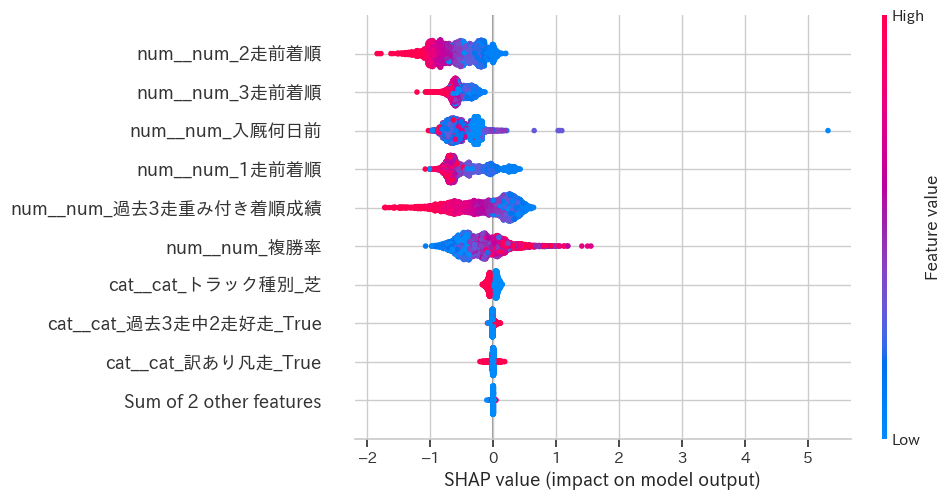

In [37]:
japanize_matplotlib.japanize()
shap.plots.beeswarm(shap_values)

## SHAP interaction values

Next look at interactions between the features.

The higher the number, the more significant the impact on the model's predictions. For example, if A and B are two features, and the interaction value for A and B is high, then we can say that the model's predictions are significantly impacted by the interaction between A and B.

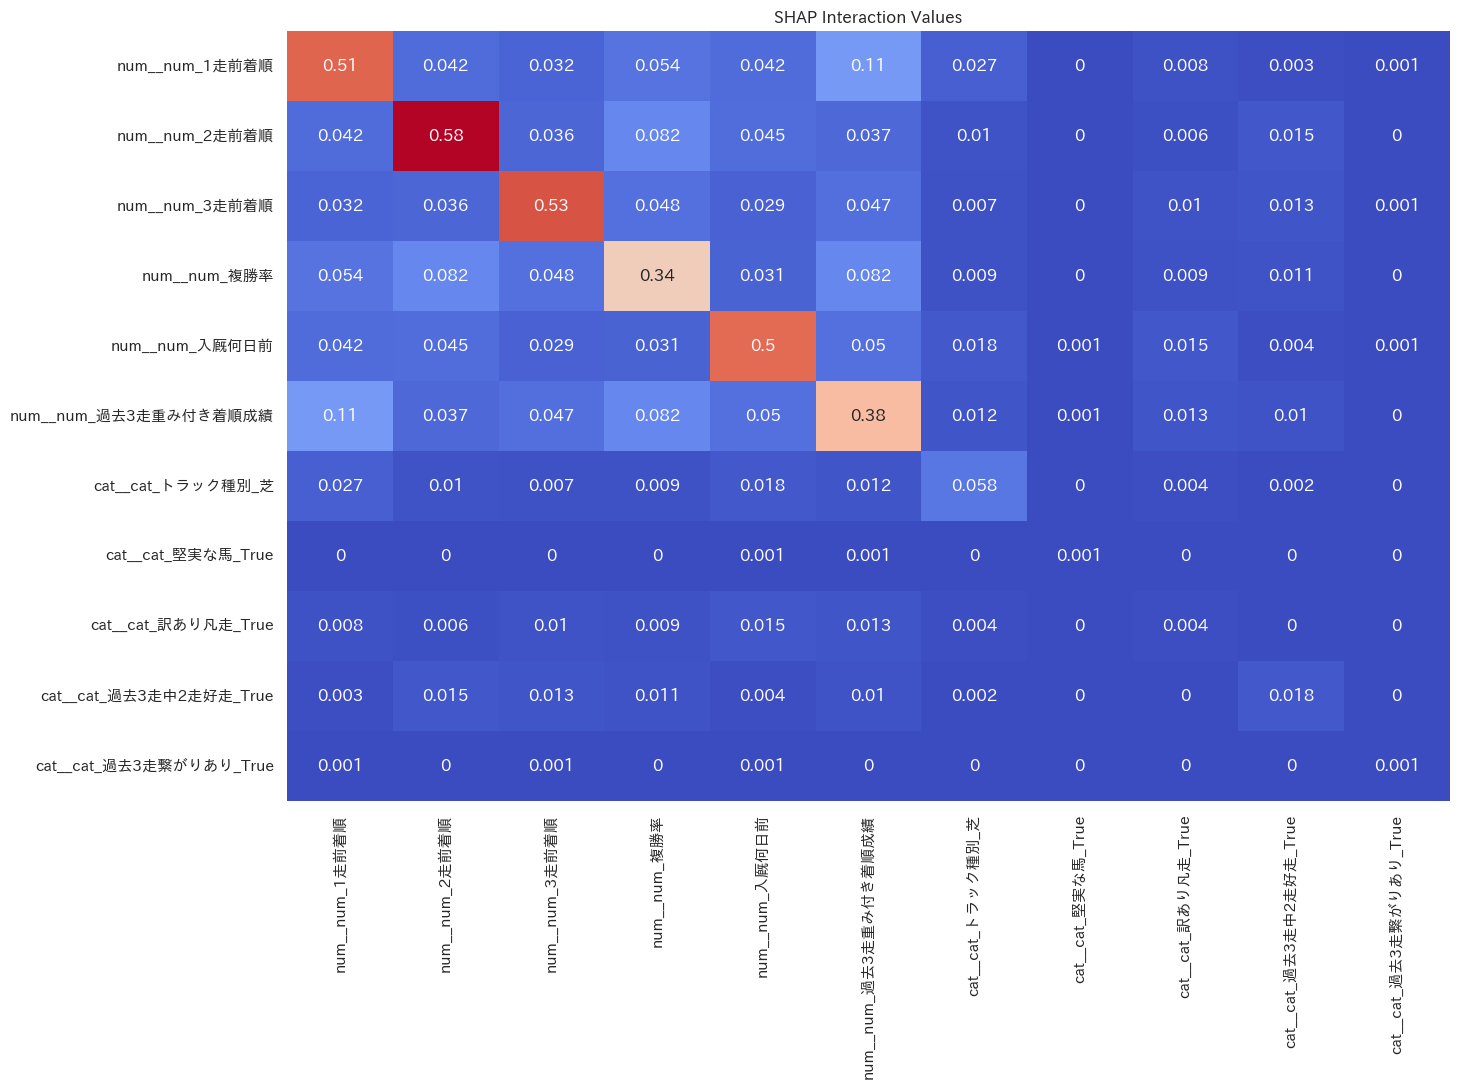

In [38]:
japanize_matplotlib.japanize()

mean_shap = np.abs(shap_interaction_values).mean(0)

df = pd.DataFrame(
    mean_shap,
    index=preprocessor.get_feature_names_out(),
    columns=preprocessor.get_feature_names_out(),
)

df.where(df.values == np.diagonal(df), df.values * 2, inplace=True)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.round(decimals=3), cmap="coolwarm", annot=True, cbar=False, ax=ax)
ax.set_title("SHAP Interaction Values")
plt.show()

## Dependence Plot

To view how two features interact with each other in relation to the predicted value, use a dependence plot.

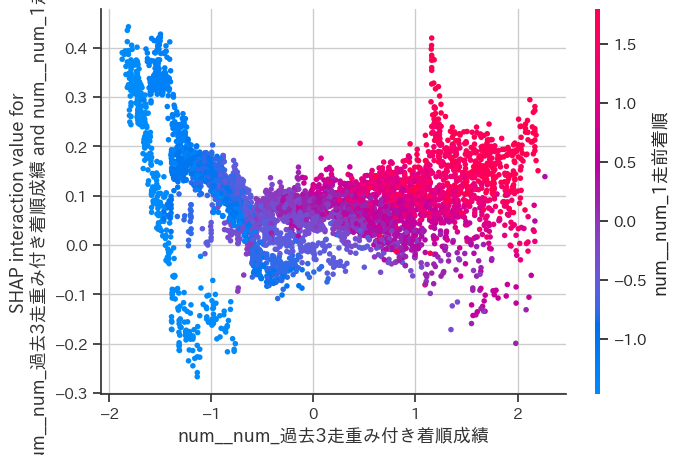

In [39]:
shap.dependence_plot(
    ind=("num__num_過去3走重み付き着順成績", "num__num_1走前着順"),
    shap_values=shap_interaction_values,
    features=X_test_prep_sample,
    feature_names=preprocessor.get_feature_names_out(),
)

### Waterfall plot

Use this plot to show how the model arrived at the final prediction given the various features. Each row shows the individual feature contribution to the final prediction.

`f(x)` is calculated with this formula (the number is the value of the prediction)

```
f(x) = ln(0.39291951 / (1 - 0.39291951))
```

The numbers in the y axis numbers (X = feature_name) are the test data as-is.

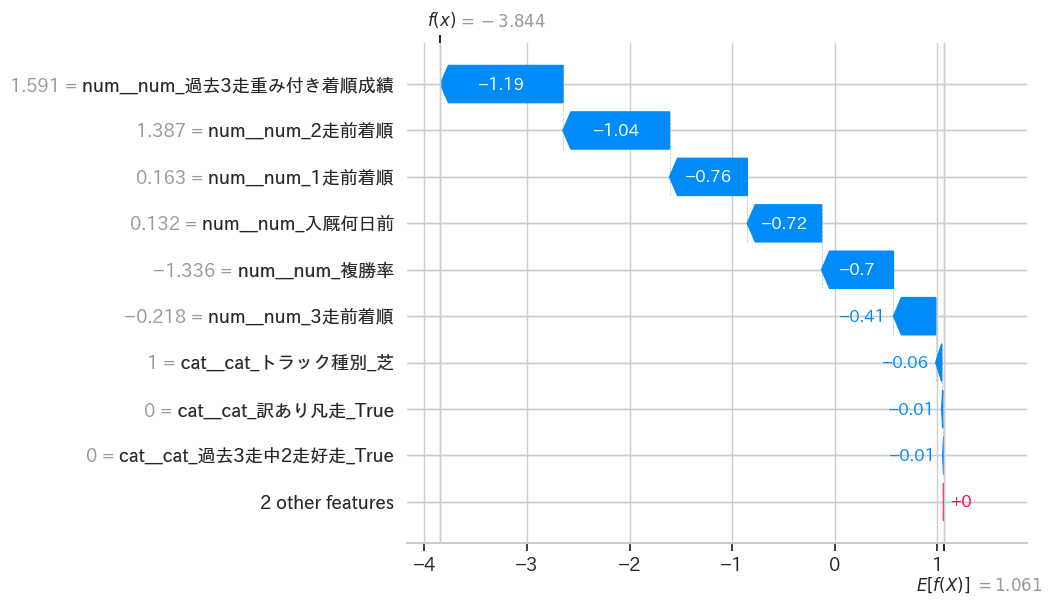

In [40]:
# ax = shap.plots.waterfall(shap_values[4], show=False)
# fig = ax.get_figure()
# fig.savefig("waterfall.png")
shap.plots.waterfall(shap_values[4])

### Stacked Force Plot

In [41]:
shap.plots.force(shap_values[0:100])

### Mean SHAP

Shows you which features are most important for a model's predictions.

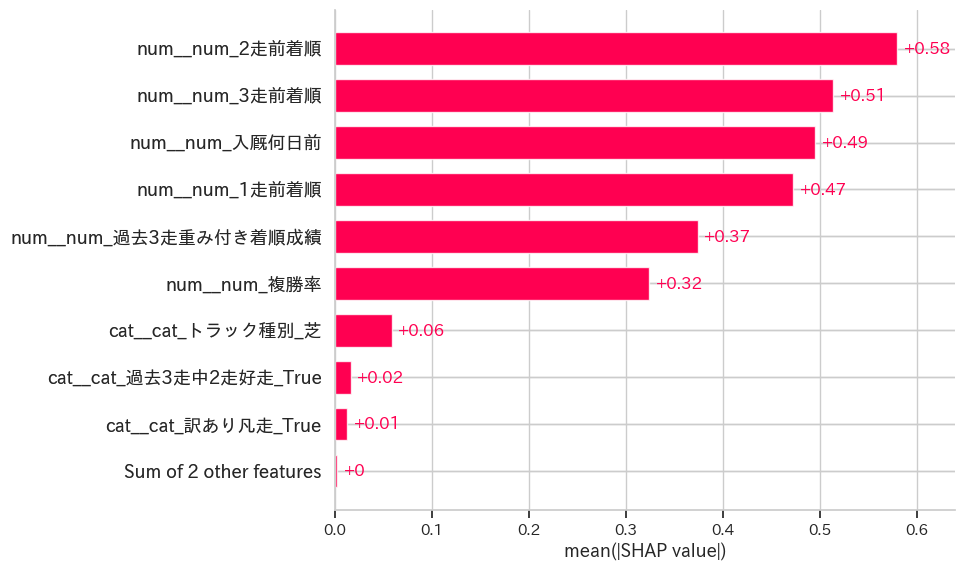

In [42]:
shap.plots.bar(shap_values)

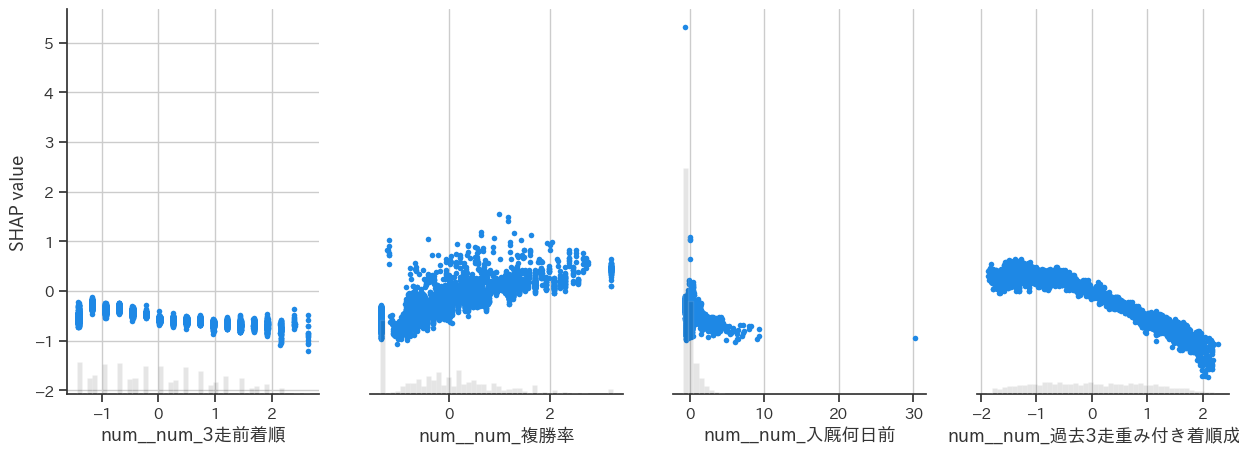

In [43]:
shap.plots.scatter(shap_values[:, 2:6])